In [9]:
# Import packages
import os
from pathlib import Path
from typing import Callable, Optional, Union

from osgeo import ogr
import geopandas as gpd
import numpy as np
import rioxarray
import xarray as xr
from xrspatial import slope
import rasterio
import pandas as pd
from rasterstats import zonal_stats
from shapely.geometry import LineString, MultiLineString
from shapely.ops import linemerge
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


# Get geometry type
def get_geom_type(fp: object) -> object:
    ds = ogr.Open(fp)
    layer = ds.GetLayer()
    return ogr.GeometryTypeToName(layer.GetLayerDefn().GetGeomType())


# Get country code from path
def get_country_code(fp: object) -> object:
    return Path(fp).parts[3]


# Get DEM name from path
def get_dem_name(fp: object) -> object:
    country_code = get_country_code(fp=fp)
    parts = Path(fp).parts
    if parts[::-1].index(country_code) == 1:
        dem_name = os.path.splitext(os.path.basename(fp))[0].split('_')[1]
    else:
        dem_name = os.path.splitext(os.path.basename(fp))[0]
    return dem_name


# Get feature type (catchment or stream) from path
def get_feature_type(fp: object) -> object:
    country_code = get_country_code(fp=fp)
    parts = Path(fp).parts
    if parts[::-1].index(country_code) == 1:
        feature_type = os.path.splitext(os.path.basename(fp))[0].split('_')[2]
    else:
        feature_type = os.path.basename(os.path.dirname(fp))[:-1]
    return feature_type


# Get CRS of vector dataset
def get_crs(fp: object) -> object:
    ds = ogr.Open(fp)
    layer = ds.GetLayer()
    return layer.GetSpatialRef().ExportToWkt()


# Path to points
def get_fp_to_points(country_code: object, dem_name: object, feature_type: object) -> object:
    return f'D:/dem_comparison/data/{country_code}/{country_code}_{dem_name}_{feature_type}_points.gpkg'


# Path to point buffers
def get_fp_to_buffers(country_code: object, dem_name: object, feature_type: object) -> object:
    return f'D:/dem_comparison/data/{country_code}/{country_code}_{dem_name}_{feature_type}_buffers.gpkg'


# Convert GeoDataFrame to line
def gdf_to_line(fp: object) -> Union[LineString, MultiLineString]:
    geom_type = get_geom_type(fp=fp)
    gdf = gpd.read_file(fp).dissolve()
    if geom_type == 'Polygon':
        line = gdf.boundary[0]
    else:
        line = gdf['geometry'][0]
    return line


# Convert line to points with 100 m intervals
def line_to_points(fp: object) -> gpd.GeoDataFrame:
    line = gdf_to_line(fp=fp)
    distances = np.arange(0, line.length, 100)
    geometries = [line.interpolate(distance) for distance in distances]
    country_code = get_country_code(fp=fp)
    dem_name = get_dem_name(fp=fp)
    feature_type = get_feature_type(fp=fp)
    ids = [f'{country_code}_{dem_name}_{feature_type}_{i:05}' for i in range(1, len(geometries) + 1)]
    points = gpd.GeoDataFrame(
        {'point_id': ids, 'country_code': country_code, 'dem_name': dem_name, 'geometry': geometries},
        crs=get_crs(fp=fp)
    )
    return points


# Create buffers for points
def points_to_buffers(points: gpd.GeoDataFrame, buff_dist: int) -> gpd.GeoDataFrame:
    buffers = points.copy()
    buffers['geometry'] = buffers.buffer(buff_dist)
    return buffers


# Process points
def process_points(fp: object):
    # Create points and export to GPKG
    points = line_to_points(fp=fp)
    country_code = get_country_code(fp=fp)
    dem_name = get_dem_name(fp=fp)
    feature_type = get_feature_type(fp=fp)
    fp_to_points = get_fp_to_points(country_code=country_code, dem_name=dem_name, feature_type=feature_type)
    try:
        os.remove(fp_to_points)
    except OSError:
        pass
    points.to_file(fp_to_points, driver='GPKG')
    # Create point buffers and export to GPKG
    buffers = points_to_buffers(points=points, buff_dist=100)
    fp_to_buffers = get_fp_to_buffers(country_code=country_code, dem_name=dem_name, feature_type=feature_type)
    try:
        os.remove(fp_to_buffers)
    except OSError:
        pass
    buffers.to_file(fp_to_buffers, driver='GPKG')
    return


# Path to slope raster
def get_fp_to_slope(country_code: object, dem_name: object) -> object:
    return f'D:/dem_comparison/data/{country_code}/{country_code}_{dem_name}_slope.tif'


# Create slope raster from DEM
def create_slope_raster(fp_to_dem: object):
    # Read DEM array
    dem_array = rioxarray.open_rasterio(fp_to_dem)
    dem_array = dem_array.where(dem_array.values != dem_array.rio.nodata)
    # Create slope array
    slope_array = slope(
        xr.DataArray(
            data=dem_array.values.squeeze(), coords={'y': dem_array['y'], 'x': dem_array['x']}, dims=['y', 'x']
        )
    )
    # Get profile from source data
    with rasterio.open(fp_to_dem, 'r') as src:
        profile = src.profile
    # Update profile
    profile.update(dtype='float32')
    profile.update(compress='LZW')
    profile.update(nodata=np.nan)
    # Write slope array to raster
    country_code = get_country_code(fp=fp_to_dem)
    dem_name = get_dem_name(fp=fp_to_dem)
    with rasterio.open(get_fp_to_slope(country_code=country_code, dem_name=dem_name), 'w', **profile) as dst:
        dst.write_band(1, slope_array)
    return


# Export zonal statistics to CSV
def stats_to_csv(stats: list, stat_name: object, fp_to_buffers: object):
    stats_df = pd.DataFrame(stats)
    if stat_name not in stats_df.columns:
        stats_df = stats_df.rename(columns={stats_df.columns[-1]: stat_name})
    stats_df = stats_df.drop(columns=[col for col in stats_df.columns if col != stat_name])
    buffers = gpd.read_file(fp_to_buffers, driver='GPKG', ignore_geometry=True)
    country_code = get_country_code(fp=fp_to_buffers)
    dem_name = get_dem_name(fp=fp_to_buffers)
    feature_type = get_feature_type(fp=fp_to_buffers)
    out_df = buffers.join(stats_df)
    out_df.to_csv(
        f'D:/dem_comparison/data/{country_code}/stats/{country_code}_{dem_name}_{feature_type}_{stat_name}.csv',
        index=False
    )
    return


# Get slope statistics
def get_slope_stats(fp_to_buffers: object, fp_to_slope: object, stat_name: Optional[object] = None):
    layer = os.path.splitext(os.path.basename(fp_to_buffers))[0]
    stats = zonal_stats(vectors=fp_to_buffers, raster=fp_to_slope, layer=layer, stats=['median'])
    stats_to_csv(stats=stats, stat_name=stat_name, fp_to_buffers=fp_to_buffers)
    return


# Get input dictionary for slope statistics
def get_slope_stats_input(
        country_code: object, dem_names: Union[object, list], feature_types: Union[object, list]) -> dict:
    input_dict = {}
    if type(dem_names) != list:
        dem_names = [dem_names]
    if type(feature_types) != list:
        feature_types = [feature_types]
    for dem_name in dem_names:
        for feature_type in feature_types:
            input_dict[get_fp_to_buffers(country_code, dem_name, feature_type)] = get_fp_to_slope(
                country_code=country_code, dem_name='AW3D30'
            )
    return input_dict


# Read raster as array and replace missing values with NaN
def read_raster_array(fp: object) -> np.array:
    with rasterio.open(fp, 'r') as src:
        array = src.read(1)
        nodata = np.nan
        if src.nodata != nodata:
            array = np.where(array == src.nodata, nodata, array)
    return array


# Get profile from raster
def get_profile(fp: object) -> rasterio.profiles.Profile:
    with rasterio.open(fp, 'r') as src:
        profile = src.profile
    return profile


# Calculate percentage of forest in point buffers
def calc_forest_pct(array: np.array) -> float:
    count = np.count_nonzero(array == 10)
    pct = count / (~np.isnan(array)).sum() * 100
    return pct


# Path to land cover raster
def get_fp_to_land_cover(country_code: object) -> object:
    return f'D:/dem_comparison/data/{country_code}/{country_code}_land_cover.tif'


# Get forest statistics
def get_forest_stats(fp_to_buffers: object, fp_to_land_cover: object, stat_name: object):
    layer = os.path.splitext(os.path.basename(fp_to_buffers))[0]
    array = read_raster_array(fp=fp_to_land_cover)
    profile = get_profile(fp=fp_to_land_cover)
    stats = zonal_stats(
        vectors=fp_to_buffers, raster=array, layer=layer, nodata=np.nan, affine=profile.get('transform'),
        stats=['count'], categorical=True, add_stats={stat_name: calc_forest_pct}
    )
    stats_to_csv(stats=stats, stat_name=stat_name, fp_to_buffers=fp_to_buffers)
    return


# Get input dictionary for forest statistics
def get_forest_stats_input(
        country_code: object, dem_names: Union[object, list], feature_types: Union[object, list]) -> dict:
    input_dict = {}
    if type(dem_names) != list:
        dem_names = [dem_names]
    if type(feature_types) != list:
        feature_types = [feature_types]
    for dem_name in dem_names:
        for feature_type in feature_types:
            input_dict[get_fp_to_buffers(country_code, dem_name, feature_type)] = get_fp_to_land_cover(
                country_code=country_code
            )
    return input_dict


# Get path to reference geometry
def get_fp_to_ref(fp: object) -> object:
    country_code = get_country_code(fp=fp)
    feature_type = get_feature_type(fp=fp)
    return f'D:/dem_comparison/data/{country_code}/{feature_type}s/Ref.shp'


# Get distance statistics
def get_dist_stats(fp_to_points: object, stat_name: object):
    fp_to_ref = get_fp_to_ref(fp=fp_to_points)
    line = gdf_to_line(fp=fp_to_ref)
    points = gpd.read_file(fp_to_points)
    # Calculate distances to reference geometry and export to CSV
    distances = []
    for point in points['geometry']:
        distances.append(point.distance(line))
    stats_to_csv(stats=distances, stat_name=stat_name, fp_to_buffers=fp_to_points)
    return


# Split MultiLineString at intersections
def split_line_at_intersections(fp: object) -> gpd.GeoDataFrame:
    line_geom = gdf_to_line(fp=fp)
    merged = linemerge([line for line in line_geom])
    gdf = gpd.GeoDataFrame(geometry=[line for line in merged], crs=get_crs(fp=fp))
    return gdf


# Calculate sinuosity of line
def calc_sinuosity(line: Union[LineString, MultiLineString]) -> float:
    points = line.boundary
    line_length = line.length
    straight_length = LineString([points[0], points[1]]).length
    return line_length / straight_length


# Calculate mean sinuosity of a line GeoDataFrame
def calc_mean_sinuosity(fp: object) -> float:
    gdf = split_line_at_intersections(fp=fp)
    gdf['sinuosity'] = gdf['geometry'].apply(calc_sinuosity)
    mean_sinuosity = round(gdf['sinuosity'].mean(), 3)
    return mean_sinuosity


# Get sinuosity statistics
def get_sinuosity_stats(country_code: object, dem_name: object):
    fp_to_streams = f'D:/dem_comparison/data/{country_code}/streams/{dem_name}.shp'
    fp_to_ref = get_fp_to_ref(fp=fp_to_streams)
    sinuosity = calc_mean_sinuosity(fp=fp_to_streams)
    ref_sinuosity = calc_mean_sinuosity(fp=fp_to_ref)
    sinuosity_diff = round((sinuosity - ref_sinuosity) / ref_sinuosity * 100, 1)
    df = pd.DataFrame(
        [{
            'Country': country_code,
            'DEM': dem_name,
            'Sinuosity': sinuosity,
            'Reference sinuosity': ref_sinuosity,
            'Difference': sinuosity_diff,
            'Absolute difference': abs(sinuosity_diff)
        }]
    )
    df.to_csv(f'D:/dem_comparison/data/{country_code}/stats/{country_code}_{dem_name}_sinuosity.csv', index=False)
    return


# Get path to statistics
def get_fp_to_stats(country_code: object, dem_name: object, feature_type: object, stat_name: object) -> object:
    return f'D:/dem_comparison/data/{country_code}/stats/{country_code}_{dem_name}_{feature_type}_{stat_name}.csv'


# Classify slope median
def classify_slope_median(row):
    if row['slope_median'] < 5:
        slope_class = '< 5'
    elif 5 <= row['slope_median'] < 10:
        slope_class = '5 - 10'
    elif 10 <= row['slope_median'] < 40:
        slope_class = '10 - 40'
    else:
        slope_class = '> 40'
    return slope_class


# Classify forest percentage
def classify_forest_pct(row):
    if row['forest_pct'] < 0.1:
        forest_class = '< 10'
    elif 0.1 <= row['forest_pct'] < 0.25:
        forest_class = '10 - 25'
    elif 0.25 <= row['forest_pct'] < 0.5:
        forest_class = '25 - 50'
    else:
        forest_class = '> 50'
    return forest_class


# Get HEX code based on color name used in R
def get_hex_code(color_name: object) -> object:
    color_dict = {
        'dodgerblue3': '#1874CD',
        'magenta2': '#EE00EE',
        'goldenrod2': '#EEB422',
        'seagreen3': '#43CD80',
        'tomato2': '#EE5C42',
        'bisque4': '#8B7D6B',
        'snow4': '#8B8989'
    }
    return color_dict.get(color_name)


# Get catchment name based on country code
def get_catchment_name(country_code: object) -> object:
    name_dict = {
        'ESP': 'Argos',
        'EST': 'Porijõgi',
        'ETH': 'Rib',
        'USA': 'Bald Eagle'
    }
    return name_dict.get(country_code)


# Read statistics into DataFrame
def read_stats(country_code: object, dem_name: object, feature_type: object, stat_name: object) -> pd.DataFrame:
    fp = get_fp_to_stats(country_code=country_code, dem_name=dem_name, feature_type=feature_type, stat_name=stat_name)
    stats = pd.read_csv(fp)
    return stats


# Merge distance statistics with the other one for plotting
def merge_stats_for_plot(
        country_code: object, dem_names: list, feature_type: object, stat_name: object) -> pd.DataFrame:
    dist_stats = pd.concat(
        [read_stats(country_code, dem_name, feature_type, 'dist_to_ref') for dem_name in dem_names]
    ).reset_index(drop=True)
    stats = pd.concat(
        [read_stats(country_code, dem_name, feature_type, stat_name) for dem_name in dem_names]
    ).reset_index(drop=True)
    merged = dist_stats.merge(stats[['point_id', stat_name]], how='left', on='point_id')
    merged = merged.sort_values(['dem_name', stat_name]).reset_index(drop=True)
    return merged


# Get axis label based on the name of the statistic
def get_label(stat_name: object) -> object:
    if stat_name == 'forest_pct':
        return 'Forest cover (%)'
    elif stat_name == 'slope_median':
        return 'Median slope (degrees)'
    return


# Get classification function based on the name of the statistic
def get_class_func(stat_name: object) -> Callable:
    if stat_name == 'forest_pct':
        return classify_forest_pct
    elif stat_name == 'slope_median':
        return classify_slope_median
    return


# Plot histogram in subplot and return it
def plot_hist(
        country_code: object, dem_names: list, feature_type: object, stat_name: object, ax: plt.Axes) -> plt.Axes:
    merged = merge_stats_for_plot(country_code, dem_names, feature_type, stat_name)
    if stat_name == 'forest_pct':
        interval = 20
        bins = range(0, 100 + interval, interval)
    elif stat_name == 'slope_median':
        interval = 5
        bins = range(0, 45 + interval, interval)
    merged[stat_name].hist(ax=ax, bins=bins)
    ax.set_xlabel(get_label(stat_name=stat_name), fontsize=16)
    if feature_type == 'basin':
        ylabel = f'Number of catchment point buffers'
    else:
        ylabel = f'Number of {feature_type} point buffers'
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_title(get_catchment_name(country_code), fontsize=16)
    ax.set_xticks(list(bins))
    ax.set_xticklabels([round(tick) for tick in ax.get_xticks()], fontsize=16)
    ax.set_yticklabels([round(tick) for tick in ax.get_yticks()], fontsize=16)
    return ax


# Plot relationship between statistic and distance to reference geometry
def plot_stat_vs_dist(
        country_code: object, dem_names: list, feature_type: object, stat_name: object, ax: plt.Axes) -> plt.Axes:
    merged = merge_stats_for_plot(country_code, dem_names, feature_type, stat_name)
    merged[f'{stat_name}_class'] = merged.apply(get_class_func(stat_name), axis=1)
    color_names = ['magenta2', 'goldenrod2', 'seagreen3', 'tomato2', 'snow4']
    palette = sns.color_palette([get_hex_code(color_name) for color_name in color_names])
    sns.boxplot(
        y='dist_to_ref', x=f'{stat_name}_class', data=merged, hue='dem_name', ax=ax, showfliers=False,
        palette=palette
    )
    ax.set_xlabel(get_label(stat_name=stat_name), fontsize=16)
    if feature_type == 'basin':
        ylabel = 'Distance to reference\n catchment (m)'
    else:
        ylabel = f'Distance to reference\n {feature_type} (m)'
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_title(get_catchment_name(country_code), fontsize=16)
    ax.set_xticklabels(merged[f'{stat_name}_class'].unique(), fontsize=16)
    ax.set_yticklabels([round(tick) for tick in ax.get_yticks()], fontsize=16)
    return ax


# Create figure with subplots and save it as PNG
def subplots_to_png(
        country_codes: list, dem_names: list, feature_type: object, stat_name: object, plot_func: Callable):
    fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex=True, sharey=True)
    for country_code, ax in zip(country_codes, axes.flatten()):
        plot_func(country_code, dem_names, feature_type, stat_name, ax=ax)
    if plot_func == plot_hist:
        fp = f'D:/dem_comparison/figures/{stat_name}_hist_{feature_type}.png'
    elif plot_func == plot_stat_vs_dist:
        fp = f'D:/dem_comparison/figures/{stat_name}_vs_dist_to_ref_{feature_type}.png'
        for ax in fig.axes:
            if ax != fig.axes[-1]:
                ax.get_legend().remove()
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()
        fig.legend(
            handles, labels, loc='lower center', ncol=5, title='DEM', bbox_to_anchor=(0.5, -0.1), title_fontsize=16,
            fontsize=16
        )
    for ax in fig.axes:
        if ax == fig.axes[0] or ax == fig.axes[1]:
            ax.set(xlabel=None)
        if ax == fig.axes[1] or ax == fig.axes[-1]:
            ax.set(ylabel=None)
    plt.tight_layout()
    plt.savefig(fp, dpi=300, bbox_inches='tight')
    return


# Plot relationship between statistic and distance to reference geometry by class
def plot_stat_vs_dist_by_class(country_codes: list, dem_names: list, feature_type: object, stat_name: object):
    merged = pd.concat(
        [merge_stats_for_plot(country_code, dem_names, feature_type, stat_name) for country_code in country_codes]
    )
    merged[f'{stat_name}_class'] = merged.apply(get_class_func(stat_name), axis=1)
    if stat_name == 'forest_pct':
        palette = 'light:seagreen'
    elif stat_name == 'slope_median':
        palette = 'dark:salmon_r'
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    sns.boxplot(
        y='dist_to_ref', x='country_code', data=merged, hue=f'{stat_name}_class', ax=ax, showfliers=False,
        palette=palette
    )
    ax.set_xticklabels([get_catchment_name(country_code) for country_code in country_codes], fontsize=16)
    ax.set_yticklabels([round(tick) for tick in ax.get_yticks()], fontsize=16)
    ax.set_xlabel('Catchment name', fontsize=16)
    if feature_type == 'basin':
        ylabel = 'Distance to reference\n catchment (m)'
    else:
        ylabel = f'Distance to reference\n {feature_type} (m)'
    ax.set_ylabel(ylabel, fontsize=16)
    plt.legend(
        loc='lower center', ncol=4, title=get_label(stat_name=stat_name), bbox_to_anchor=(0.5, -0.4),
        title_fontsize=16, fontsize=16
    )
    plt.tight_layout()
    fp = f'D:/dem_comparison/figures/{stat_name}_vs_dist_to_ref_{feature_type}_by_class.png'
    plt.savefig(fp, dpi=300, bbox_inches='tight')
    return

In [10]:
# Input parameters
country_codes = ['ESP', 'EST', 'ETH', 'USA']
dem_names = ['AW3D30', 'HydroSHEDS', 'MERIT', 'NASADEM', 'TanDEM']
feature_types = ['basin', 'stream']

In [11]:
# stat_names = ['slope_median']
# merged_list = []
# for country_code in country_codes:
#     for feature_type in feature_types:
#         for stat_name in stat_names:
#             merged = merge_stats_for_plot(country_code, dem_names, feature_type, stat_name)
#             merged['feature_type'] = feature_type
#             # merged = merged.drop(stat_name, axis=1)
#             merged_list.append(merged)
# dist_df = pd.concat(merged_list).reset_index(drop=True)

In [12]:
# for feature_type in feature_types:
#     fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharey=True)
#     for country_code, ax in zip(country_codes, axes.flatten()):
#         plot_stat_vs_dist(country_code, dem_names, feature_type, stat_names[0], ax=ax)

C:\Users\Holger\AppData\Local\Temp\ipykernel_20488\4006099982.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(tick) for tick in ax.get_yticks()], fontsize=16)


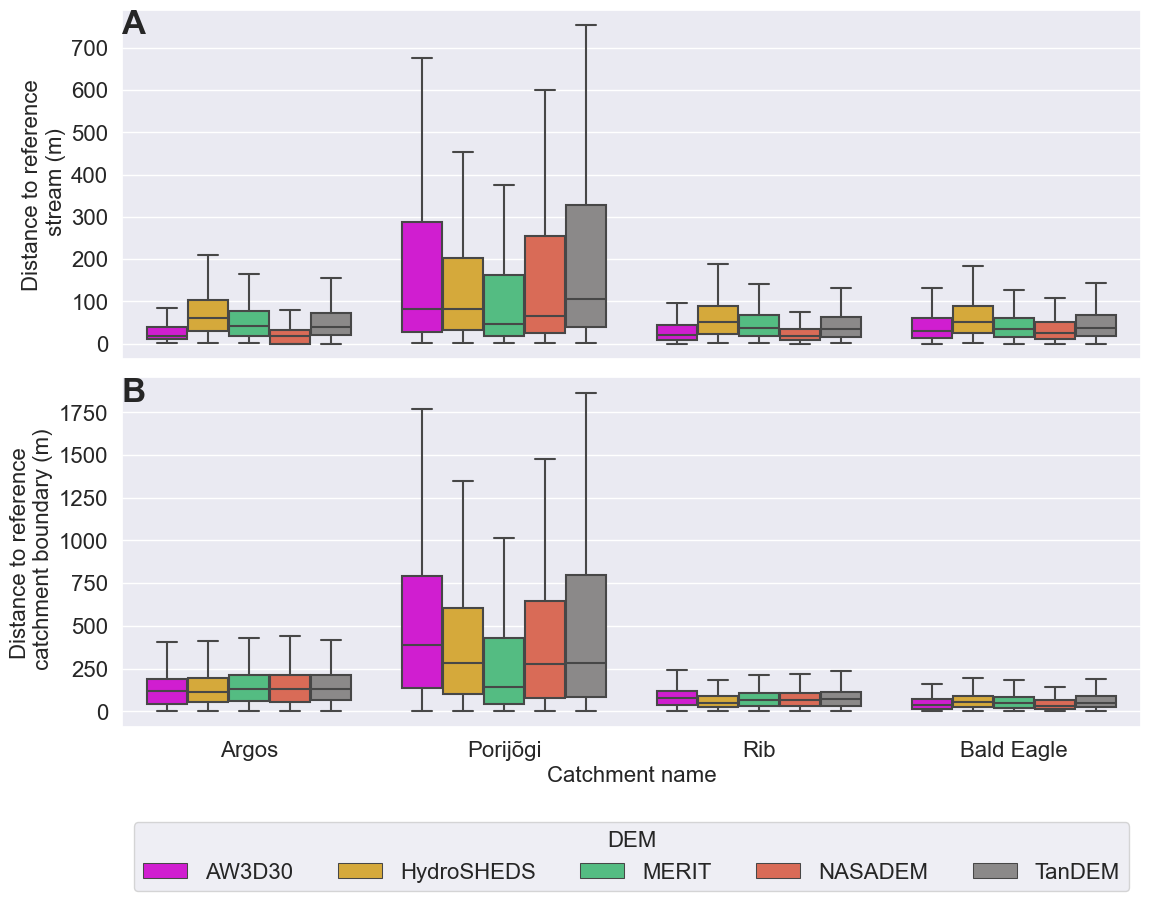

In [8]:
# Read statistics and create DataFrame
country_codes = ['ESP', 'EST', 'ETH', 'USA']
dem_names = ['AW3D30', 'HydroSHEDS', 'MERIT', 'NASADEM', 'TanDEM']
feature_types = ['basin', 'stream']

# Create figure and save as PNG
color_names = ['magenta2', 'goldenrod2', 'seagreen3', 'tomato2', 'snow4']
sns.set_palette(sns.color_palette([get_hex_code(color_name) for color_name in color_names]))
fig, axes = plt.subplots(2, 1, figsize=(12, 9), sharex=True)

# Plot streams
feature_type = 'stream'
df_list = []
for country_code in country_codes:
    dist_stats = pd.concat(
        [read_stats(country_code, dem_name, feature_type, 'dist_to_ref') for dem_name in dem_names]
    ).reset_index(drop=True)
    df_list.append(dist_stats)
stats_df = pd.concat(df_list).reset_index(drop=True)
stats_df = stats_df.sort_values(['country_code', 'dem_name'])
sns.boxplot(y='dist_to_ref', x='country_code', data=stats_df, hue='dem_name', ax=axes[0], showfliers=False)
axes[0].set_xlabel(None)
ylabel = f'Distance to reference\n {feature_type} (m)'
axes[0].set_ylabel(ylabel, fontsize=16)
axes[0].text(0, 1, 'A', ha='left', va='top', transform=axes[0].transAxes, size=24, weight='bold')

# Plot basins
feature_type = 'basin'
df_list = []
for country_code in country_codes:
    dist_stats = pd.concat(
        [read_stats(country_code, dem_name, feature_type, 'dist_to_ref') for dem_name in dem_names]
    ).reset_index(drop=True)
    df_list.append(dist_stats)
stats_df = pd.concat(df_list).reset_index(drop=True)
stats_df = stats_df.sort_values(['country_code', 'dem_name'])
sns.boxplot(y='dist_to_ref', x='country_code', data=stats_df, hue='dem_name', ax=axes[1], showfliers=False)
axes[1].set_xlabel('Catchment name', fontsize=16)
ylabel = f'Distance to reference\n catchment boundary (m)'
axes[1].set_ylabel(ylabel, fontsize=16)
axes[1].text(0, 1, 'B', ha='left', va='top', transform=axes[1].transAxes, size=24, weight='bold')

for ax in axes.flatten():
    if ax != fig.axes[-1]:
        ax.get_legend().remove()
    ax.set_xticklabels([get_catchment_name(country_code) for country_code in country_codes], fontsize=16)
    ax.set_yticklabels([round(tick) for tick in ax.get_yticks()], fontsize=16)
    for container in ax.containers:
        ax.bar_label(container, fontsize=16)
plt.legend(loc='lower center', ncol=5, title='DEM', bbox_to_anchor=(0.5, -0.5), title_fontsize=16, fontsize=16)
plt.tight_layout()
plt.savefig(f'D:/dem_comparison/figures/dist_to_ref.png', dpi=300)